### División de los datos: Clase DataSplit

Este notebook tiene como objetivo describir el proceso de división de los datos bajo la premisa de que el conjunto de testeo tendrá parches pertenecientes a cuadrantes y/o tiempos que la red nunca vio durante su proceso de entrenamiento. Esto con el fin de evitar evaluar el rendimiento de la red con información redudante. 

La idea de la división de los datos es la siguiente:

>>Se tomarán el 5% de las fechas consecutivas + 10% de fechas al azar. Luego tomar el 5% de los cuadrantes y 5% de parches al azar. Con todo al anterior, se formará el conjunto de testeo.

Los porcentajes a elegir son una variable más. 

#### 1. Preparación de los parches:

La clase ```DataSplit```, a cargo de llevar a cabo la división de la data, asume que los parches fueron construidos de manera ordenada. Es decir: 
- Cada 156 parches cambia el registro temporal. En otras palabras, los primeros 156 parches están asociados al registro temporal 1, los 156 que vienen después al registro temporal 2 y así sucesivamente con todos los registros utilizados para construir los parches.
- Cada 156 parches, comenzando por los primeros 156, describen a un mapa completo. Es decir, cada parche tiene su cuadrante específico dentro del stack que se mantiene igual cada 156 parches. 

Este orden en los parches permite trabajar únicamente con los índices en lugar de construir reiteradas operaciones sobre el stack completo de parches, lo cual puede ser costoso en términos de memoria. 

#### 2. Variables importantes: 

Las variables principales de la clase ```DataSplit``` son 4: 
- etiquetas_cuadrantes[i]: Lista cuyos elementos son tuplas: (i, id). El primer valor $i$ hace referencia al índice del parche respecto al stack mientras que el segundo valor contiene el id del cuadrante al que pertenece el parche en la posición $i$. ( $id \in \lbrace 0, ..., 155 \rbrace$)
- etiquetas_tiempos[i]: Contiene el id del tiempo al que pertenece el parche $i$. ( $id \in \lbrace 0, ..., 599 \rbrace$)
- idx_cuadrantes: Lista que contiene los 156 id que describen la posición de los cuadrantes. 
- idx_tiempos: Lista que contiene los 600 cuadrantes que describen la posición de los cuadrantes. Este número surge de la construcción del stack de parches utilizando los 120 registros temporales de los 5 primeros casos del dataset. 

Para visualizar de mejor la manera cómo se relacionan las variables anteriores se entrega el siguiente cuadro:

| parches[i]   | cuadrante id  | tiempo id   | etiqueta_cuadrante | etiqueta_tiempo     
| ------- |-------| --------|  ------ | ------- | 
|0 | 0 | 0 | (0,0) | (0,0)|
|1 | 1  | 0 | (1,1) | (1,0)|
|2 | 2  | 0  | (2,2) | (2,0)|
|... | ... | ... | ... | ... |
|155 | 155 | 0 | (155,155) | (155,0)|
|156 | 0  | 1 | (156,0) | (156,1)|
|157 | 1  | 1 | (157,1) | (157,1)|
|... | ... | ... | ... | ...|
|93599 | 155 | 599 | (93599, 155) | (93599,599)|

De esta manera, si decidimos quitar el cuadrante 50, por ejemplo, basta con extraer todos los índices de los parches cuya ```etiqueta_cuadrante``` sea igual a 50 (49 considerando la indexación de python). Con estos índices extraídos iremos construyendo el conjunto de testeo. Una vez ya hayamos extraído todos los índices requeridos, con el método ```tf.gather([indices])``` podemos extraer los parches del stack completo y formar el conjunto de testeo. 

#### 3. Métodos de la clase DataSplit:

Desmenuzando la idea de la división de los datos, necesitaremos atender las siguientes operaciones:
- Extraer un porcentaje de registros temporales consecutivos
- Extraer una muestra aleatoria de registros temporales
- Extraer una muestra aleatoria de cuadrantes
- Extraer una muestra aleatoria de parches.

Partamos por las operaciones relacionadas al tiempo.

##### 3.1 Extracción intervalo temporal: 

Dado que ```idx_tiempos``` contiene el id de todos los registros temporales de nuestro stack, solo necesitamos extraerle una porción. Para ello definimos un inicio aleatorio dentro de la lista: ```idx_inicio``` y extraemos el trozo de la longitud que nos interesa con la indexación propia de las listas. Este trozo de id's lo utilizaremos para filtrar los valores de ```idx_tiempos```y quedarnos con los cuadrantes que no se encuentran en los extraídos. 

In [1]:
import numpy as np 
import random 

parches=np.zeros((93600, 32, 32)) #simulando el stack de parches
cant_tiempos= 600 #Cantidad de tiempos
porc_intervalo= 0.05 #Porcentaje del intervalo a extraer
len_intervalo= int(cant_tiempos * porc_intervalo)

idx_tiempos = list(range(cant_tiempos)) #id's con los tiempos
print("Cantidad de id-tiempos antes de la filtración: ", len(idx_tiempos))

idx_inicio = random.randint(0, len(idx_tiempos) - len_intervalo ) #Definimos el inicio del intervalo a extraer
tiempo_intervalo = idx_tiempos[idx_inicio: idx_inicio + len_intervalo] #Definimos el intervalo a extraer
idx_tiempos = [ valor for  valor in idx_tiempos if valor not in tiempo_intervalo] #Filtramos el intervalo

print("Cantidad de tiempos extraídos: ", len(tiempo_intervalo))
print("Cantidad de tiempos post extracción: ", len(idx_tiempos))

Cantidad de id-tiempos antes de la filtración:  600
Cantidad de tiempos extraídos:  30
Cantidad de tiempos post extracción:  570


#### 3.2 Extracción muestras temporales:
Aplicada la primera extracción a nuestra variable: ```idx_tiempos```, corresponde ahora extraerle una muestra aleatoria de id's. Para ello nos ayudaremos del método ```random.sample```.

In [2]:
porc_muestra=0.1 #tamaño del muestreo a extraer
len_muestra= int(cant_tiempos * porc_muestra) #Cantidad de id's a extraer
tiempo_muestra = random.sample(idx_tiempos, len_muestra ) #definición de los id de la muestra
idx_tiempos = [ idx for idx in idx_tiempos if idx not in tiempo_muestra] #Filtramos la muestra

print("Cantidad de tiempos de la muestra: ", len(tiempo_muestra))
print("Cantidad de tiempos post extracción: ", len(idx_tiempos))

Cantidad de tiempos de la muestra:  60
Cantidad de tiempos post extracción:  510


Ahora que ya definimos cuáles son los id's de los tiempos que nos interesa filtrar en nuestro stack de parches, corresponde realizar dicha operación. Lo más rápido en términos de código (pero no en eficiencia) es filtrar, tal cual como lo hemos hecho en la variable ```idx_tiempos```, cuáles son los parches cuya etiqueta temporal se encuentran en los id removidos. Esta última información la obtenemos simplemente uniendo las variables ```tiempo_intervalo```, la cual contiene los id del intervalo temporal removido, y ```tiempo_muestra```, que contiene los id de la muestra extraída. Esta gran filtración la haremos sobre la variable ```etiquetas_tiempos```. 

In [3]:
etiquetas_tiempos   = np.zeros((parches.shape[0], 1)) 
for t in range(cant_tiempos):
    etiquetas_tiempos[156*t:156*(t+1)]=t #Cada 155 parches, cambia el registro temporal

print("Cantidad de parches al inicio: ", len(etiquetas_tiempos))
etiquetas_tiempos= list ( enumerate (etiquetas_tiempos))
tiempo_extraer=tiempo_intervalo + tiempo_muestra  #listado con los id a filtrar
idx_parches_tiempo= [ idx for idx, valor in etiquetas_tiempos if valor not in tiempo_extraer] #Primera gran filtración

print("Algunos tiempos-id's a remover: ",tiempo_extraer[:10])
print("Algunos id de parches post filtración: ", idx_parches_tiempo[:10] )
print("Cantidad de parches post extracción tiempo: ", len(idx_parches_tiempo))
print("Cantidad de parches removidos: ", len(etiquetas_tiempos) - len(idx_parches_tiempo))

Cantidad de parches al inicio:  93600
Algunos tiempos-id's a remover:  [150, 151, 152, 153, 154, 155, 156, 157, 158, 159]
Algunos id de parches post filtración:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Cantidad de parches post extracción tiempo:  79560
Cantidad de parches removidos:  14040


Con esto hemos removido 14040 parches en nuestro primer proceso de extracción. Corresponde hacerlo ahora para los cuadrantes.

#### 3.3 Extracción muestra de cuadrantes:
Aplicaremos la misma metodología para la extracción de cuadrantes. Lo que nos interesa ahora es simplemente extraer una muestra aleatorias de id's de la variable ```idx_cuadrantes```

In [4]:
cant_cuadrantes= 156
porc_cuadrantes=0.05
idx_cuadrantes=list(range(cant_cuadrantes))
cuad_muestra= random.sample(idx_cuadrantes, int(cant_cuadrantes * porc_cuadrantes))  #Def. id's de la muestra
idx_cuadrantes= [cuad for cuad in idx_cuadrantes if cuad not in cuad_muestra] #Filtración de id's 

print("Tamaño de la muestra de cuadrantes: ", len(cuad_muestra))
print("Cantidad de cuadrantes restantes: ",len(idx_cuadrantes))

Tamaño de la muestra de cuadrantes:  7
Cantidad de cuadrantes restantes:  149


Resta ahora filtrar los parches cuya etiqueta coincida con los parches removidos. Un detalle interesante es que aplicamos la segunda gran filtración sobre la variable ```etiquetas_cuadrantes```, que contiene las etiquetas de todos los parches y no solo de los ya filtrados en ```idx_parches_tiempo```. Lo hacemos de esta manera ya que estamos interesados en conocer cuáles son los índices de los parches a remover: ```idx_parches_cuad_extraer``` para luego, a través de una resta de listas, conocer los índices de los parches a mantener: ```idx_parches_mantener```. Este método es mucho más rápido que la filtración comparando elemento a elemento como lo hicimos en la extracción temporal (casi 10 veces más rápido)

In [5]:
etiquetas_cuadrantes= np.zeros((parches.shape[0], 1)) 
for cuad in range(cant_cuadrantes):
    idx= list( range(cuad,parches.shape[0],156) ) #cada 156, misma id
    etiquetas_cuadrantes[idx]= cuad

etiquetas_cuadrantes= list ( enumerate (etiquetas_cuadrantes))
idx_parches_cuad_extraer   = [ idx for idx, valor in etiquetas_cuadrantes if valor in cuad_muestra] 
idx_parches_mantener= list( set(idx_parches_tiempo) -  set(idx_parches_cuad_extraer) ) 


print("Cantidad de parches extraídos: ", len(idx_parches_cuad_extraer))
print("Cantidad de parches posterior extracción espacial: ", len(idx_parches_mantener))

Cantidad de parches extraídos:  4200
Cantidad de parches posterior extracción espacial:  75990


#### 3.4 Extracción muestra de parches:

Para la última extracción necesitamos definir una muestra aleatoria de parches a remover. Este proceso es idéntico al aplicado en la extracción de la muestra temporal y la de los cuadrantes, solo que ahora lo haremos sobre la variable ```ídx_parches_mantener``` la cual contiene el índice de todos los parches a conservar. Finalmente esta variable contendrá todos los índices de los parches a mantener. Para conocer cuáles son los parches que conformarán el conjunto de testeo, basta con restar los índices originales menos los a mantener.

In [6]:
porc_muestra=0.1
etiquetas = [idx for idx, _ in etiquetas_cuadrantes] 
len_parches_mantener=len(idx_parches_mantener)

idx_parches_mantener= random.sample(idx_parches_mantener, int(  len(idx_parches_mantener) * ( 1 - porc_muestra) ) )
idx_parches_extraer= list( set(etiquetas )- set(idx_parches_mantener))
print("Cantidad de parches a mantener: ", len(idx_parches_mantener))
print("Cantidad de parches a extraer: ", len(idx_parches_extraer))

Cantidad de parches a mantener:  68391
Cantidad de parches a extraer:  25209


Con eso concluye el proceso de división de los datos. Sin embargo, es importante mencionar un par de cosas más:
- ```idx_parches_extraer``` contiene los índices de los parches que conformarán el conjunto de testeo. 
- Las variables adicionales creadas en la clase ```DataSplit``` permiten que este proceso de división se ejecute nuevamente sobre los índices restantes, de tal manera de, si se requiere, construir un conjunto de validación independiente al conjunto de entrenamiento y testeo. Sin embargo, la idea detrás de la clase es exactamente lo mismo que lo recién descrito.
- Este método no asegura ningún tipo de estratificación en los conjuntos sino que busca únicamente una independencia empírica entre el conjunto de entrenamiento y el conjunto de testeo.

#### 4. Chequeo independencia de los conjuntos.
Lo único que nos resta por revisar es si efectivamente los conjuntos creados son independientes a nivel de parches. En otras palabras, la suma de ```idx_parches_mantener``` y ```idx_parches_extraer``` debe ser igual a la cantidad de parches del stack, y su resta debe ser vacía.

In [7]:
suma_conjuntos= len(idx_parches_mantener) + len(idx_parches_extraer)

if parches.shape[0] == suma_conjuntos:
    print("La cantidad de elementos coincide")

entrenamiento= set(idx_parches_mantener)
testeo= set(idx_parches_extraer)

if entrenamiento.isdisjoint(testeo):
    print("Las listas no tienen elementos en común.")
else:
    print("Las listas tienen elementos en común.")

La cantidad de elementos coincide
Las listas no tienen elementos en común.


#### 5. Algunas visualizaciones: 
##### Visualización de los tiempos-id extraídos

Text(0.5, 1.0, 'Cantidad de tiempos extraídos 90 de 600 ')

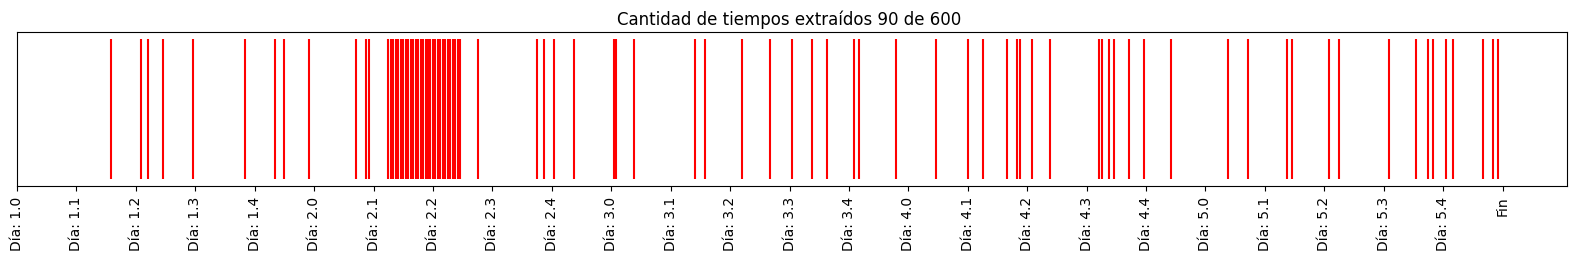

In [8]:
import matplotlib.pyplot as plt 

indices_extraer= tiempo_extraer


tiempos=np.zeros(cant_tiempos)
tiempos[indices_extraer] = 1
indices=list(range(cant_tiempos))
x= np.array(indices)[indices_extraer]
y= tiempos[indices_extraer]

plt.figure(figsize=(20, 2))
plt.stem(
        x, y, linefmt="red", markerfmt=' ', basefmt=' ')  
plt.gca().set_yticks([])


etiquetas = []
for dia in range(1, 6):  # Días del 1 al 5
    for subdia in range(0, 5):  
        etiqueta = f"Día: {dia}.{subdia}"
        etiquetas.append(etiqueta)

etiquetas.append("Fin")

intervalo = 24
marcas_x = range(0, len(tiempos) + intervalo, intervalo)
plt.xticks(marcas_x, etiquetas, rotation='vertical') 


plt.title(f"Cantidad de tiempos extraídos {len(indices_extraer)} de {cant_tiempos} ")


#### 6. Clase Data_split()

In [9]:
import matplotlib.pyplot as plt 
import numpy as np 
import random 

parches=np.zeros((93600, 32, 32))

class Data_split: 

    def __init__(self, parches, indices=None, seed=None):

        self.parches=parches      #[tensor] Recibe el tensor con los parches
        self.seed=seed            #[int]    Semilla para la extracción aleatoria de muestras
        self.indices=indices      #[List]   Índices de parches a conservar 
        self.etiquetas_cuadrantes= np.zeros((self.parches.shape[0], 1)) #Array que contendrá el id del cuadrante al que pertenece cada parche
        self.etiquetas_tiempos   = np.zeros((self.parches.shape[0], 1)) #Array que contendrá el id del tiempo al que pertenece cada parche 
        self.cant_cuadrantes=156  #Cantidad de cuadrantes.
        self.cant_tiempos= int(parches.shape[0] / 156)  #Cantidad de registros temporales distintos
             
        if self.seed is not None:
            random.seed(self.seed) 

    def init_etiquetas(self):

        ''' Definición de las variables de clase que contendrán las 
        etiquetas del cuadrante y tiempo al que pertenece cada parche i.
        En caso de que la variable self.indice sea None, se trabajará con todos los parches. 
        
        Nota: self.etiquetas_cuadrantes: Cuadrante {0,1,...,155} al que pertenece el parche i
              self.etiquetas_tiempos: Tiempo {0,1,2,...,599} al que pertenece el parche i
        '''  
        #cantidad de cuadrantes dado los parches de tamaño 32x32
        for cuad in range(self.cant_cuadrantes):
            idx= list( range(cuad,parches.shape[0],156) )
            self.etiquetas_cuadrantes[idx]= cuad

        for t in range(self.cant_tiempos):
            self.etiquetas_tiempos[156*t:156*(t+1)]=t

        if self.indices is None: 

            self.etiquetas_cuadrantes= list ( enumerate ( self.etiquetas_cuadrantes))
            self.etiquetas_tiempos   = list ( enumerate ( self.etiquetas_tiempos   ))
            self.etiquetas = [idx for idx, _ in self.etiquetas_cuadrantes]

        else:
            self.etiquetas_cuadrantes=self.etiquetas_cuadrantes[self.indices]
            self.etiquetas_tiempos=self.etiquetas_tiempos[self.indices]
            self.etiquetas_cuadrantes= list(zip(self.indices , self.etiquetas_cuadrantes))
            self.etiquetas_tiempos   = list(zip(self.indices, self.etiquetas_tiempos))
            self.etiquetas= self.indices 
            
        print(f" {len(self.etiquetas_cuadrantes)} etiquetas espaciales y temporales creadas correctamente")


        
    def intervalo_temporal(self, porc_intervalo=0.05,indices=None, verbose=False):

        ''' Método encargado de extraer un intervalo continuo de valores de tiempo (self.tiempo_intervalo)
            de la variable idx_tiempos. La variable idx_tiempos contiene inicialmente todos los valores posibles 
            de tiempo. Si índice es None, se trabajarán con todos los registros temporales. 
            
            Nota: invariante a la cantidad de parches.

        input: 
            porc_intervalo: [float]  porcentaje ]0,1[ de tiempos a extraer 
            verbose: [Booleano] si True, imprime información relacionada al intervalo extraído 
            
        return:
            self.tiempo_intervalo: [Lista] Valores del intervalo de tiempos extraído. 
        '''

        self.idx_tiempos= list(range(self.cant_tiempos)) 
        if self.indices is not None:
            self.idx_tiempos=[idx for idx in self.idx_tiempos if idx not in indices]
        len_intervalo= int(self.cant_tiempos * porc_intervalo) #invariable
        idx_inicio = random.randint(0, len(self.idx_tiempos) - len_intervalo )
        self.tiempo_intervalo = self.idx_tiempos[idx_inicio: idx_inicio + len_intervalo] 
        self.idx_tiempos = [ valor for  valor in self.idx_tiempos if valor not in self.tiempo_intervalo]

        if verbose:
            print("Proceso 1: Extracción intervalo temporal")
            print("Cantidad de tiempos extraidos: ", len(self.tiempo_intervalo))
            print("Cantidad de tiempos restantes: ", len(self.idx_tiempos))
            print("-"*60)

        return self.tiempo_intervalo
    
    def muestra_temporal(self, porc_muestra=0.1, verbose=False): 

        ''' Método encargado de extraer una muestra aleatoria: tiempo_muestra, de tiempos de 
        la variable self.idx_tiempos. 
        
        Nota: Invariante respecto a la cantidad de parches.

        input: 
        porc_muestra: [float] porcentaje ]0.1[ que define el tamaño de la muestra a extraer. 
        verbose: [Booloeano] si True, imprime información relacionada a la muestra extraída. 

        return:
            self.tiempo_muestra: [lista] Valores de tiempo de la muestra extraída. 
        '''

        len_muestra= int( self.cant_tiempos * porc_muestra)
        self.tiempo_muestra = random.sample(self.idx_tiempos, len_muestra )
        self.idx_tiempos = [ idx for idx in self.idx_tiempos if idx not in self.tiempo_muestra]

        if verbose:
            print("Proceso 2: Extracción muestra temporal")
            print("Cantidad de tiempos extraidos: ", len(self.tiempo_muestra))
            print("Cantidad de tiempos restantes: ", len(self.idx_tiempos))
            print("-"*60)
            
        return self.tiempo_muestra 
    
    def extraccion_temporal(self, verbose=True):

        ''' Método encargado de extraer los parches cuya etiqueta coincide con los tiempos extraídos:
        tiempo_extraer, en los métodos anteriores. 

        input: 
            verbose: [Booleano] si True, imprime información de la cantidad de parches extraídos.

        return:
            idx_extraer= valores de los tiempos a extraer.
        '''

        self.tiempo_extraer= self.tiempo_intervalo + self.tiempo_muestra 
        self.idx_parches_tiempo= [ indice for indice, valor in self.etiquetas_tiempos if valor not in self.tiempo_extraer]
        
        if verbose: 

            print("Proceso 3: Exclusión de parches dado etiquetado temporal")
            print("Cantidad de tiempos extraídos totales: ",len(self.tiempo_extraer))
            print("Cantidad de parches original: ", len(self.etiquetas_tiempos))
            print("Cantidad de parches extraídos: ", len(self.etiquetas_tiempos) - len(self.idx_parches_tiempo)  )
            print("Cantidad de parches restantes: ", len(self.idx_parches_tiempo))
            print("-"*60)

        return self.tiempo_extraer

    def muestra_espacial(self, porc_cuadrantes=0.05, indices= None, verbose=False):

        ''' Método encargado de extraer una muestra aleatoria de cuadrantes de la variable: self.idx_cuadrantes
        que contiene todos los valores de los cuadrantes. Si indices is None, se trabaja con todos los cuadrantes.

        input:
            poc_cuadrantes: [float] Porcentaje ]0,1[ que define el tamaño de la muestra a extraer.
            verbose: [Booleano] si True, imprime información relacionada a los cuadrantes extraídos

        return:
            self.cuad_muestra
        '''

        self.idx_cuadrantes=list(range(self.cant_cuadrantes))
        if indices is not None:
            self.idx_cuadrantes= [idx for idx in self.idx_cuadrantes if idx not in indices]
        self.cuad_muestra= random.sample(self.idx_cuadrantes, int(self.cant_cuadrantes * porc_cuadrantes))  
        self.idx_cuadrantes= [cuad for cuad in self.idx_cuadrantes if cuad not in self.cuad_muestra]

        if verbose:
            print("Proceso 4: Extracción de cuadrantes")
            print("Cantidad de cuadrantes extraidos: ", len(self.cuad_muestra))
            print("Cantidad de cuadrantes restantes: ", len(self.idx_cuadrantes))
            print("-"*60)

        return self.cuad_muestra
    
    def extraccion_espacial(self, verbose=False):

        ''' Método encargado de extraer todos los parches cuya etiqueta coincide con los cuadrantes
        extraidos en el método anterior.

        input:
            verbose: [Booleano] si True, imprime información relacionada a los cuadrantes extraídos
        
        return:
            self.idx_parches_mantener
        '''

        self.idx_parches_cuad_extraer   = [ indice for indice, valor in self.etiquetas_cuadrantes if valor in self.cuad_muestra] 
        self.idx_parches_mantener= list( set(self.idx_parches_tiempo) -  set(self.idx_parches_cuad_extraer) ) 

        if verbose:
            print("Proceso 5: Exclusión de parches dado etiquetado cuadrante.")
            print("Cantidad de parches extraídos: ", len(self.idx_parches_cuad_extraer))
            print("Cantidad de parches posterior extracción espacial: ", len(self.idx_parches_mantener))
            print("-"*60)
        
        return self.idx_parches_mantener 
    
    def extraccion_final(self, porc_muestra=0.1, verbose=False):

        ''' Método encargado de extraer una muestra aleatoria de parches.

        input: 
            poc_cuadrantes: [float] Porcentaje ]0,1[ que define el tamaño de la muestra a extraer.
            verbose: [Booleano] si True, imprime información relacionada a los cuadrantes extraídos

        return:
            self.idx_parches_mantener 
            self.idx_parches_extraer
        '''

        self.len_parches_mantener=len(self.idx_parches_mantener)
        self.idx_parches_mantener= random.sample(self.idx_parches_mantener, int(  len(self.idx_parches_mantener) * ( 1 - porc_muestra) ) )
        self.idx_parches_extraer= list (set(self.etiquetas) - set(self.idx_parches_mantener))
        
        if verbose:
            print("Proceso 6: Extracción de muestra aleatoria.")
            print("Cantidad de parches extraídos: ", self.len_parches_mantener - len(self.idx_parches_mantener))
            print("cantidad de parches restantes: ", len(self.idx_parches_mantener))
            print("-"*60)
            print("Resumen: ")
            print("Cantidad de parches restantes final: ", len(self.idx_parches_mantener) )
            print("Cantidad de parches extraídos final: ", len(self.idx_parches_extraer) )

        return self.idx_parches_mantener, self.idx_parches_extraer



In [10]:
def grafico_temporal(indices_extraer):


    cant_tiempos=600
    tiempos=np.zeros(cant_tiempos)
    tiempos[indices_extraer] = 1
    indices=list(range(cant_tiempos))
    x= np.array(indices)[indices_extraer]
    y= tiempos[indices_extraer]

    plt.figure(figsize=(20, 2))
    plt.stem(
        x, y, linefmt="#193737", markerfmt=' ', basefmt=' ')  
    plt.gca().set_yticks([])


    etiquetas = []
    for dia in range(1, 6):  # Días del 1 al 5
        for subdia in range(0, 5):  
            etiqueta = f"Día: {dia}.{subdia}"
            etiquetas.append(etiqueta)

    etiquetas.append("Fin")

    intervalo = 24
    marcas_x = range(0, len(tiempos) + intervalo, intervalo)
    plt.xticks(marcas_x, etiquetas, rotation='vertical') 


    plt.title(f"Cantidad de tiempos extraídos {len(indices_extraer)} de {cant_tiempos} ")

In [11]:
def grafico_espacial(freq_cuad, counter_cuad): 


    data = np.random.random((12, 13))
    for idx in freq_cuad:
        fila = idx[0] // data.shape[1]
        columna = idx[0] % data.shape[1]
        data[fila,columna] = idx[1]


    #Etiquetas
    xlabs=[]; ylabs=[]
    for i in range(13):
        xlabs.append(str(i))

    for j in range(12):
        ylabs.append(str(j))

         
    #Mapa de calor
    fig, ax = plt.subplots(figsize=(18, 8))
    im = ax.imshow(data)

    
    ax.set_xticks(np.arange(len(xlabs)), labels = xlabs)
    ax.set_yticks(np.arange(len(ylabs)), labels = ylabs)
    ax.set_title("Parches por cuadrante del conjunto de entrenamiento", fontsize=10)


    for i in range(len(ylabs)  ):
        for j in range(len(xlabs)  ):
                text = ax.text(j, i, int(data[i, j]),
                          ha = "center", va = "center", color = "w", fontsize=8)
        
    #Agregar la leyenda
    cbar = ax.figure.colorbar(im, ax = ax)
    cbar.ax.set_ylabel("Frecuencias", rotation = -90, va = "top")
    vmax=counter_cuad.most_common()[1][1]
    vmin=counter_cuad.most_common()[-1][1]
    im.set_clim(vmin,vmax)

    plt.show() 

#### 7. Implementación de la clase:
Si bien puede parecer poco práctico la implementación método a método de la clase para dividir los conjuntos, la ventaja que ofrece hacerlo de esta manera es poder acceder a toda la información relevante de la propia clase: cuadrantes y tiempos removidos y a mantener. Sin embargo, en caso de querer hacerlo de una manera más directa, se pueden encapsular todos estos métodos en uno mayor dentro de la clase y retornar únicamente los índices de cada conjunto.

In [12]:
test= Data_split(parches=parches, seed=20)
test.init_etiquetas()
intervalo_temporal = test.intervalo_temporal(verbose=True)
idx_random         = test.muestra_temporal(verbose=True)
tiempos_extraer    = test.extraccion_temporal(verbose=True)
idx_cuadrantes     = test.muestra_espacial(verbose=True)
idx_mantener       = test.extraccion_espacial(verbose=True)
treino, te         = test.extraccion_final(verbose=True)

 93600 etiquetas espaciales y temporales creadas correctamente
Proceso 1: Extracción intervalo temporal
Cantidad de tiempos extraidos:  30
Cantidad de tiempos restantes:  570
------------------------------------------------------------
Proceso 2: Extracción muestra temporal
Cantidad de tiempos extraidos:  60
Cantidad de tiempos restantes:  510
------------------------------------------------------------
Proceso 3: Exclusión de parches dado etiquetado temporal
Cantidad de tiempos extraídos totales:  90
Cantidad de parches original:  93600
Cantidad de parches extraídos:  14040
Cantidad de parches restantes:  79560
------------------------------------------------------------
Proceso 4: Extracción de cuadrantes
Cantidad de cuadrantes extraidos:  7
Cantidad de cuadrantes restantes:  149
------------------------------------------------------------
Proceso 5: Exclusión de parches dado etiquetado cuadrante.
Cantidad de parches extraídos:  4200
Cantidad de parches posterior extracción espacial:

In [13]:
test_2=Data_split(parches=parches,indices=treino, seed=20)
test_2.init_etiquetas()
intervalo_temporal_2 = test_2.intervalo_temporal(indices= tiempos_extraer, verbose=True )
idx_random_2         = test_2.muestra_temporal(verbose=True)
tiempos_extraer_2    = test_2.extraccion_temporal(verbose=True)
idx_cuadrantes_2     = test_2.muestra_espacial(indices=idx_cuadrantes, verbose=True)
idx_mantener_2       = test_2.extraccion_espacial(verbose=True)
treino_2, te_2       = test_2.extraccion_final( porc_muestra=0.2, verbose=True)

 68391 etiquetas espaciales y temporales creadas correctamente
Proceso 1: Extracción intervalo temporal
Cantidad de tiempos extraidos:  30
Cantidad de tiempos restantes:  480
------------------------------------------------------------
Proceso 2: Extracción muestra temporal
Cantidad de tiempos extraidos:  60
Cantidad de tiempos restantes:  420
------------------------------------------------------------
Proceso 3: Exclusión de parches dado etiquetado temporal
Cantidad de tiempos extraídos totales:  90
Cantidad de parches original:  68391
Cantidad de parches extraídos:  12079
Cantidad de parches restantes:  56312
------------------------------------------------------------
Proceso 4: Extracción de cuadrantes
Cantidad de cuadrantes extraidos:  7
Cantidad de cuadrantes restantes:  142
------------------------------------------------------------
Proceso 5: Exclusión de parches dado etiquetado cuadrante.
Cantidad de parches extraídos:  3201
Cantidad de parches posterior extracción espacial:

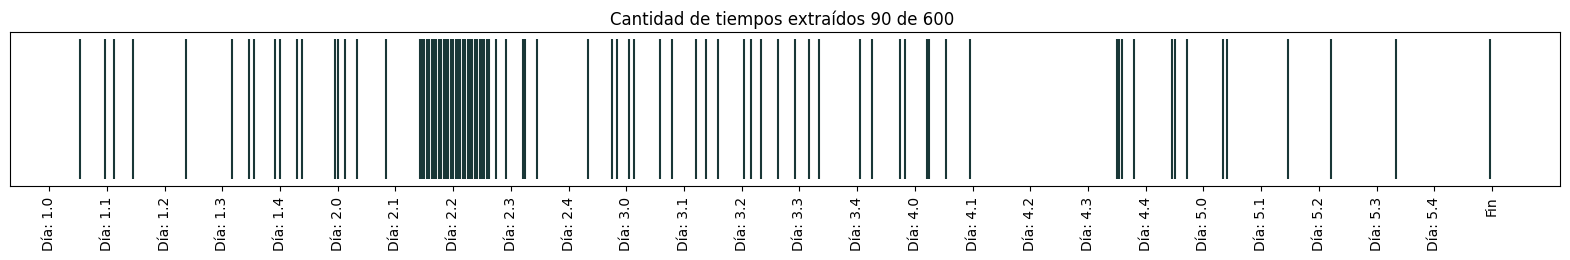

In [14]:
grafico_temporal(test.tiempo_extraer)

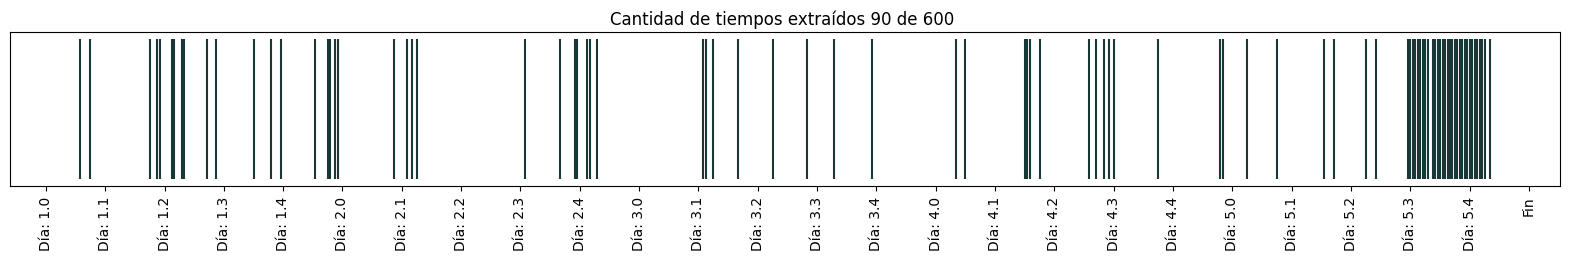

In [15]:
grafico_temporal(test_2.tiempo_extraer)

#### 8. Más plots

In [16]:
from collections import Counter

treino.sort()
te.sort() 

def calcular_frecuencias(indices, idx_cuadrantes):

    cuadrantes= [ int(test.etiquetas_cuadrantes[idx][1][0]) for idx in indices]
    counter_cuad= Counter(cuadrantes)
    freq_cuadrantes= list(counter_cuad.items())

    
    for cuad in idx_cuadrantes:
        freq_cuadrantes.append( [cuad,0])

    freq_cuadrantes=  sorted(freq_cuadrantes, key=lambda x: x[0])
    return freq_cuadrantes, counter_cuad

freq_cuadrantes, counter_cuad = calcular_frecuencias(treino, idx_cuadrantes)
print("Cantidad de cuadrantes: ", len(freq_cuadrantes))

Cantidad de cuadrantes:  156


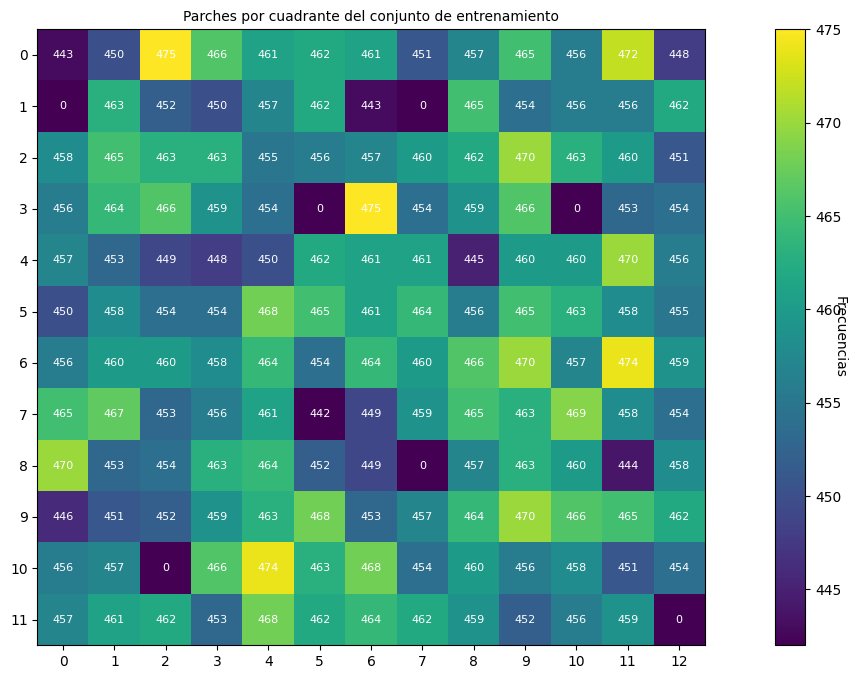

In [17]:
grafico_espacial(freq_cuadrantes, counter_cuad)

range(0, 1104, 24)
46 ['Día: 1.0', 'Día: 1.1', 'Día: 1.2', 'Día: 1.3', 'Día: 1.4']


ValueError: zero-size array to reduction operation minimum which has no identity

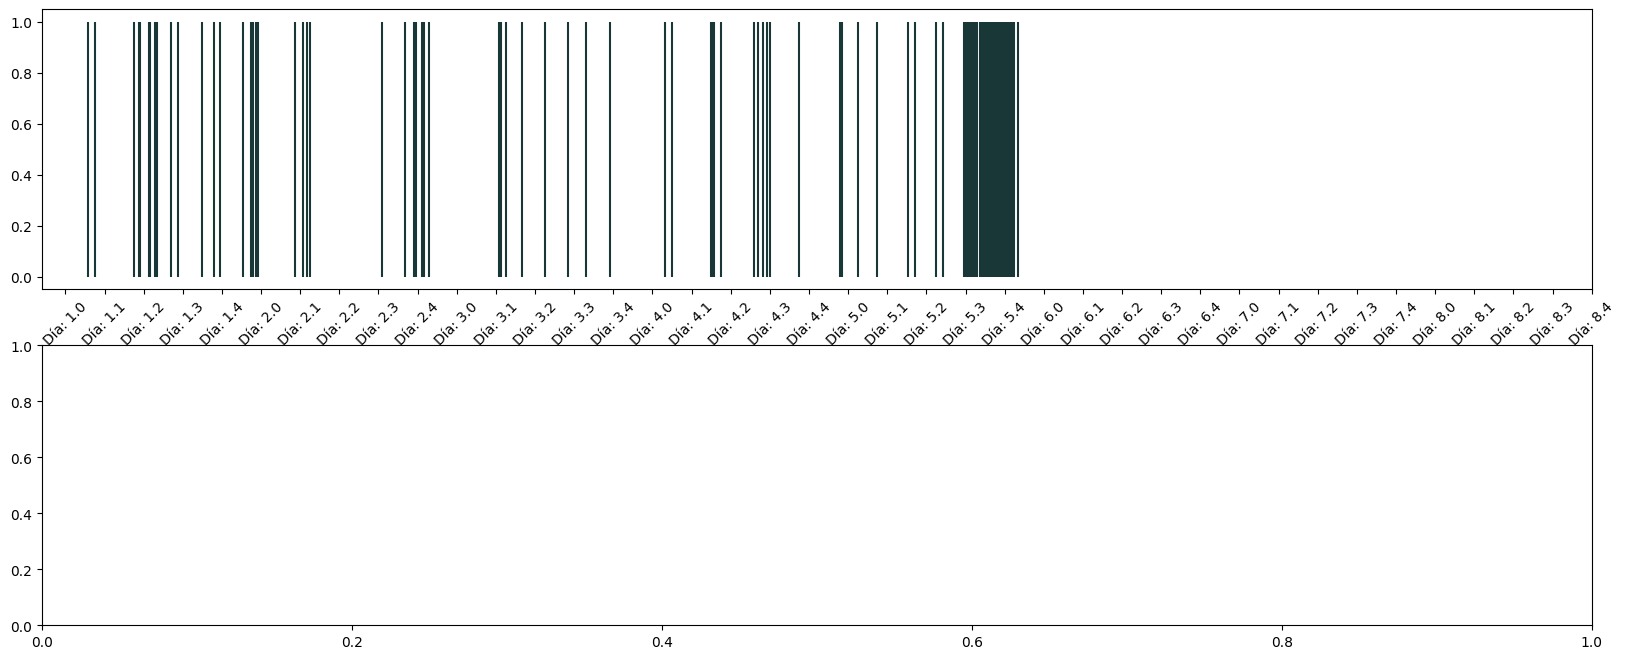

In [123]:
def grafico_temporal_2(indices_extraer, cant_casos):

    cant_tiempos=cant_casos * 120 
    tiempos = np.zeros(cant_tiempos)
    tiempos[indices_extraer] = 1 
    indices=list(range(cant_tiempos))
    x= np.array(indices)[indices_extraer]
    y= tiempos[indices_extraer]


    #Creado de etiquetas para los ejes
    etiquetas = []
    for dia in range(1, cant_casos + 1):  # Días del 1 al 5
        for subdia in range(0, 5):  
            etiqueta = f"Día: {dia}.{subdia}"
            etiquetas.append(etiqueta)
    etiquetas.append("Fin")


    intervalo = 24
    marcas_x = range(0, len(tiempos) + intervalo, intervalo)
    #plt.xticks(marcas_x, etiquetas, rotation='vertical') 
    print(marcas_x)
    print(len(etiquetas), etiquetas[:5])

    num_plots = ( cant_casos + 7) // 8 
    fig, axs = plt.subplots(num_plots, 1, figsize=(20, 4 * num_plots))

    if num_plots == 1:
        axs = [axs] 

    for i in range(num_plots): 
    

        axs[i].stem(x[ (960*i) : (960*(i+1))], y[ (960*i) : (960*(i+1))], linefmt="#193737", markerfmt=' ', basefmt=' ') 
        
        axs[i].set_xticks( list(marcas_x)[ (40*i): (40*(i+1))], etiquetas[ (40*i) : (40*(i+1))])
        axs[i].tick_params(axis='x', rotation=45) 

        etiquetas = []
        for dia in range(1, cant_casos):  # Días del 1 al 5
            for subdia in range(0, 5):  
                etiqueta = f"Día: {dia}.{subdia}"
                etiquetas.append(etiqueta)
    plt.tight_layout()
    plt.show()


grafico_temporal_2(test_2.tiempo_extraer, 9)
